In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import print_function
import keras
from keras.utils import to_categorical
import os
from keras.preprocessing.image import ImageDataGenerator, load_img
import time

C:\Users\micha\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.applications import VGG16

vgg_conv = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [3]:
vgg_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [4]:
import sys

def progress(count, total, status=''):
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))

    percents = round(100.0 * count / float(total), 1)
    bar = '=' * filled_len + '-' * (bar_len - filled_len)

    sys.stdout.write('[%s] %s%s ...%s\r' % (bar, percents, '%', status))
    sys.stdout.flush()

In [5]:
train_dir = './clean-dataset/train'
validation_dir = './clean-dataset/validation'
test_dir = './test'

#Count number of base image files in training and validation directories
nTrainImages = sum([len(files) for r, d, files in os.walk(train_dir)])
nValImages = sum([len(files) for r, d, files in os.walk(validation_dir)])

#Number of times a randomly modified image will be generated from a base image
dataAugmentation = 5
                  
#Total number of examples that will be available for the model
nTrain = nTrainImages*dataAugmentation
nVal = nValImages  #Validation images are not modified

batch_size_max = 30  #Maximum number of images to generate at a time. Adjust for performance (i.e. images must fit in memory)

#Determine batch generation sizes as largest factor smaller or equal to max batch size
for n in range(2,nTrainImages):
    if (nTrainImages%n==0) & (n<=min(nTrainImages,32)):
        train_gen_batch_size=n
        
for n in range(2,nValImages):
    if (nValImages%n==0) & (n<=min(nValImages,32)):
        val_gen_batch_size=n

print("Train new model on",str(nTrain),"examples using batch size of",train_gen_batch_size,"to augment data")
print("Validate model on",str(nVal),"examples using batch size of",val_gen_batch_size,"to augment data")

Train new model on 900 examples using batch size of 30 to augment data
Validate model on 51 examples using batch size of 17 to augment data


We need to calculate the values of the activations at the last layer of the VGG16 model which is of shape (7 x 7 x 512).
To do this, we will calculate and store the predictions for our training data using the model as it is currently loaded (i.e. without the top, final layer).  These predictions will be stored in the train_features vector of size (nTrain x 7 x 7 x 512).
This vector will serve as input to the new layers we will add to the model later.


In [6]:
t1=time.monotonic()  #Get current time to calculate overall running time

#Setup the image data generator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

batch_size = train_gen_batch_size

#Initialize the features and labels arrays to zero
train_features = np.zeros(shape=(nTrain, 7, 7, 512))
train_labels = np.zeros(shape=(nTrain,3))

temp_dir=None
#temp_dir = './temp'


i = 0
for inputs_batch, labels_batch in datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    save_to_dir=temp_dir):
    try:
        print("Batch",i,"out of",nTrain/batch_size,"[",i*batch_size,":",(i+1)*batch_size,"]")
        features_batch = vgg_conv.predict(inputs_batch)
        print("features_batch:",features_batch.shape)
        train_features[i * batch_size:(i+1)*batch_size] = features_batch
        train_labels[i * batch_size:(i+1)*batch_size] = labels_batch
        i += 1
        if (i+1) * batch_size >= nTrain:
            break
    except:
        print("***ERROR***")
        print("i:",str(i))
        break
train_features = np.reshape(train_features, (nTrain, 7 * 7 * 512))
print("Time to train : ",str(time.monotonic()-t1))

Found 180 images belonging to 3 classes.
Batch 0 out of 30.0 [ 0 : 30 ]
features_batch: (30, 7, 7, 512)
Batch 1 out of 30.0 [ 30 : 60 ]
features_batch: (30, 7, 7, 512)
Batch 2 out of 30.0 [ 60 : 90 ]
features_batch: (30, 7, 7, 512)
Batch 3 out of 30.0 [ 90 : 120 ]
features_batch: (30, 7, 7, 512)
Batch 4 out of 30.0 [ 120 : 150 ]
features_batch: (30, 7, 7, 512)
Batch 5 out of 30.0 [ 150 : 180 ]
features_batch: (30, 7, 7, 512)
Batch 6 out of 30.0 [ 180 : 210 ]
features_batch: (30, 7, 7, 512)
Batch 7 out of 30.0 [ 210 : 240 ]
features_batch: (30, 7, 7, 512)
Batch 8 out of 30.0 [ 240 : 270 ]
features_batch: (30, 7, 7, 512)
Batch 9 out of 30.0 [ 270 : 300 ]
features_batch: (30, 7, 7, 512)
Batch 10 out of 30.0 [ 300 : 330 ]
features_batch: (30, 7, 7, 512)
Batch 11 out of 30.0 [ 330 : 360 ]
features_batch: (30, 7, 7, 512)
Batch 12 out of 30.0 [ 360 : 390 ]
features_batch: (30, 7, 7, 512)
Batch 13 out of 30.0 [ 390 : 420 ]
features_batch: (30, 7, 7, 512)
Batch 14 out of 30.0 [ 420 : 450 ]
feat

In [7]:
validation_features = np.zeros(shape=(nVal, 7, 7, 512))
validation_labels = np.zeros(shape=(nVal,3))

batch_size = val_gen_batch_size

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

#Use seed=1 to maintain validation set composition between tests
validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=1)

i = 0
for inputs_batch, labels_batch in validation_generator:
    print("Batch",i,"out of",nVal/batch_size,"[",i*batch_size,":",(i+1)*batch_size,"]")
    features_batch = vgg_conv.predict(inputs_batch)
    validation_features[i * batch_size:(i+1)*batch_size] = features_batch
    validation_labels[i * batch_size:(i+1)*batch_size] = labels_batch
    i += 1
    if (i+1) * batch_size >= nVal:
        break

validation_features = np.reshape(validation_features, (nVal, 7 * 7 * 512))

Found 51 images belonging to 3 classes.
Batch 0 out of 3.0 [ 0 : 17 ]
Batch 1 out of 3.0 [ 17 : 34 ]


### Create your own model and train the network

In [8]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=7 * 7 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features,
                    train_labels,
                    epochs=20,
                    batch_size=batch_size,
                    validation_data=(validation_features,validation_labels))

Train on 900 samples, validate on 51 samples
Epoch 1/20
900/900 [==============================] - 16s 17ms/step - loss: 1.3314 - acc: 0.5767 - val_loss: 0.6058 - val_acc: 0.7843
Epoch 2/20
900/900 [==============================] - 15s 17ms/step - loss: 0.5605 - acc: 0.7667 - val_loss: 0.9038 - val_acc: 0.6667
Epoch 3/20
900/900 [==============================] - 15s 17ms/step - loss: 0.3455 - acc: 0.8656 - val_loss: 0.3295 - val_acc: 0.8627
Epoch 4/20
900/900 [==============================] - 16s 17ms/step - loss: 0.2650 - acc: 0.8911 - val_loss: 0.8810 - val_acc: 0.7451
Epoch 5/20
900/900 [==============================] - 16s 17ms/step - loss: 0.1857 - acc: 0.9322 - val_loss: 0.4048 - val_acc: 0.8824
Epoch 6/20
900/900 [==============================] - 16s 17ms/step - loss: 0.1648 - acc: 0.9444 - val_loss: 0.4303 - val_acc: 0.8431
Epoch 7/20
900/900 [==============================] - 16s 17ms/step - loss: 0.1106 - acc: 0.9567 - val_loss: 0.3289 - val_acc: 0.8627
Epoch 8/20
900/90

In [9]:
fnames = validation_generator.filenames

ground_truth = validation_generator.classes

label2index = validation_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

In [10]:
predictions = model.predict_classes(validation_features)
prob = model.predict(validation_features)

In [11]:
errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),nVal))

No of errors = 19/51


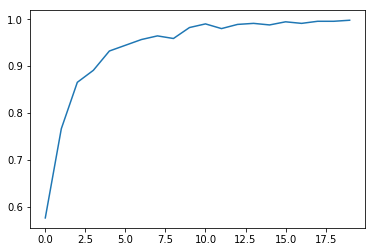

In [14]:
from matplotlib import pyplot
# plot metrics
pyplot.plot(history.history['acc'])
pyplot.show()

### Let us see which images were predicted wrongly

Original label:cheese\Cheese678.jpg, Prediction :yogurt, confidence : 0.964


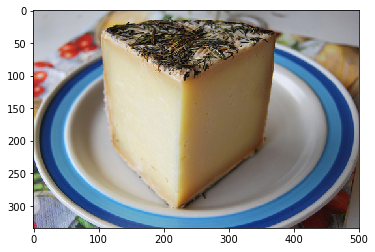

Original label:milk\Milk638.jpg, Prediction :yogurt, confidence : 1.000


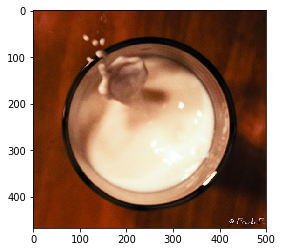

Original label:milk\Milk771.jpg, Prediction :cheese, confidence : 0.335


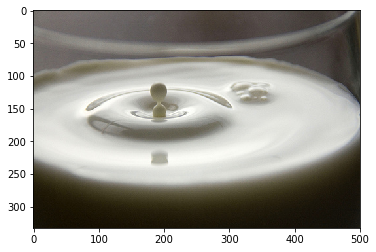

Original label:milk\Milk779.jpg, Prediction :cheese, confidence : 0.335


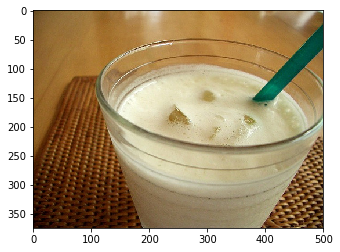

Original label:milk\Milk834.jpg, Prediction :cheese, confidence : 0.335


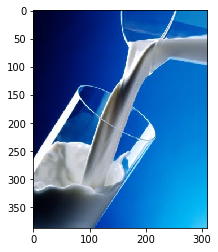

Original label:milk\Milk837.jpg, Prediction :cheese, confidence : 0.335


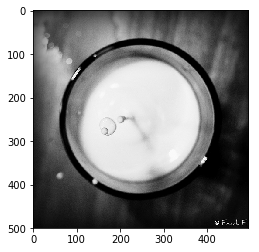

Original label:milk\Milk848.jpg, Prediction :cheese, confidence : 0.335


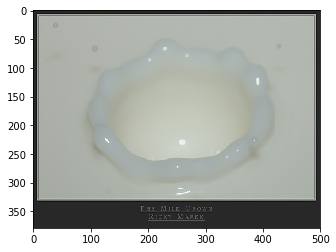

Original label:milk\Milk855.jpg, Prediction :cheese, confidence : 0.335


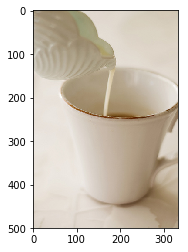

Original label:yogurt\Yogurt678.jpg, Prediction :cheese, confidence : 0.335


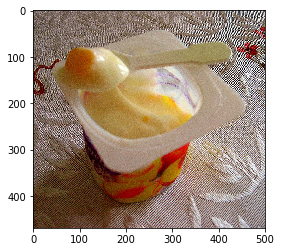

Original label:yogurt\Yogurt717.jpg, Prediction :cheese, confidence : 0.335


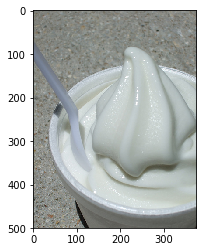

Original label:yogurt\Yogurt718.jpg, Prediction :cheese, confidence : 0.335


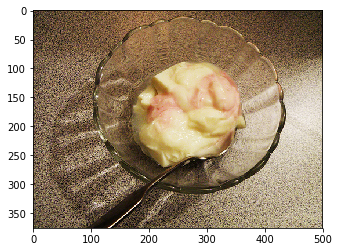

Original label:yogurt\Yogurt747.jpg, Prediction :cheese, confidence : 0.335


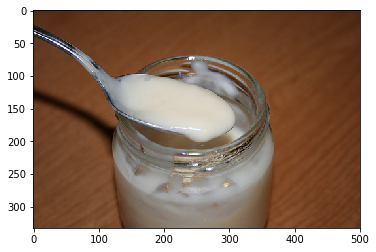

Original label:yogurt\Yogurt778.jpg, Prediction :cheese, confidence : 0.335


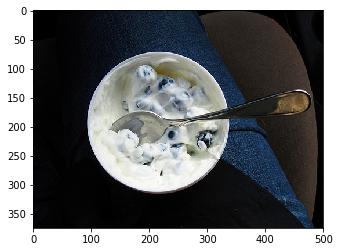

Original label:yogurt\Yogurt790.jpg, Prediction :cheese, confidence : 0.335


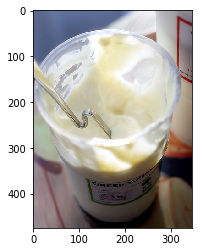

Original label:yogurt\Yogurt795.jpg, Prediction :cheese, confidence : 0.335


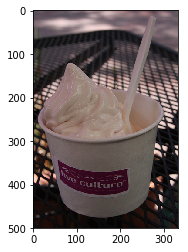

Original label:yogurt\Yogurt815.jpg, Prediction :cheese, confidence : 0.335


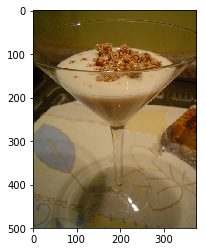

Original label:yogurt\Yogurt819.jpg, Prediction :cheese, confidence : 0.335


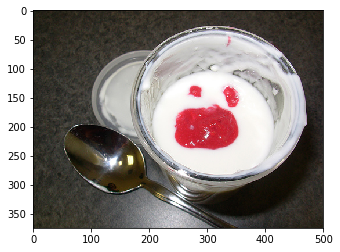

Original label:yogurt\Yogurt822.jpg, Prediction :cheese, confidence : 0.335


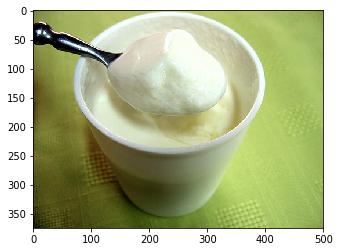

Original label:yogurt\Yogurt826.jpg, Prediction :cheese, confidence : 0.335


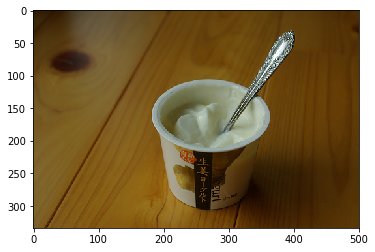

In [12]:
for i in range(len(errors)):
    pred_class = np.argmax(prob[errors[i]])
    pred_label = idx2label[pred_class]
    
    print('Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        prob[errors[i]][pred_class]))
    
    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.imshow(original)
    plt.show()

# Use the code below to save the model and weights to disk

In [39]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


# Use the code below to open and compile the saved model and weights

In [44]:
# load json and create model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(optimizer=optimizers.RMSprop(lr=2e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
score = loaded_model.evaluate(validation_features, validation_labels, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
acc: 96.08%


# Use the code below to test model on new images

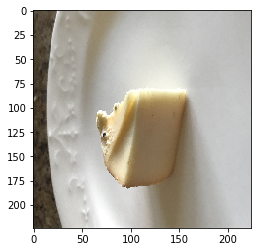

20180729_135708789_iOS.jpg is cheese 99.99732971191406 % sure.


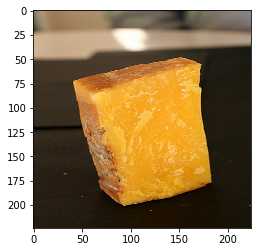

Cheese527.jpg is cheese 100.0 % sure.


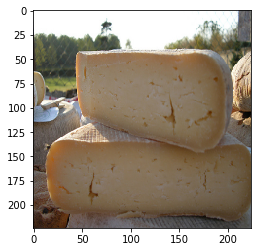

Cheese530.jpg is cheese 100.0 % sure.


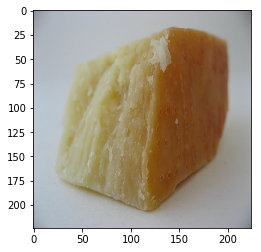

Cheese540.jpg is cheese 99.99985694885254 % sure.


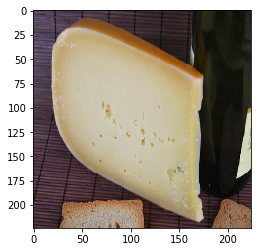

Cheese559.jpg is cheese 100.0 % sure.


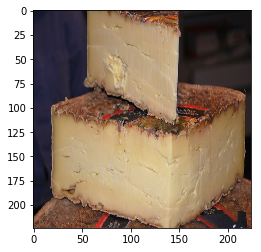

Cheese561.jpg is cheese 100.0 % sure.


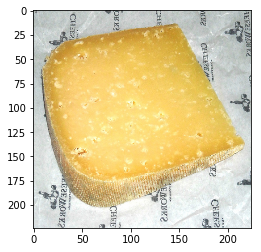

Cheese562.jpg is cheese 99.99983310699463 % sure.


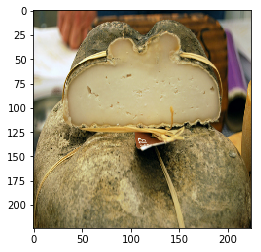

Cheese563.jpg is cheese 100.0 % sure.


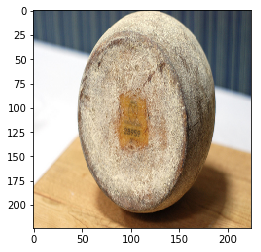

Cheese564.jpg is cheese 99.9990463256836 % sure.


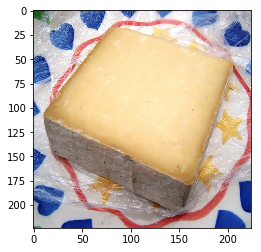

Cheese567.jpg is cheese 100.0 % sure.


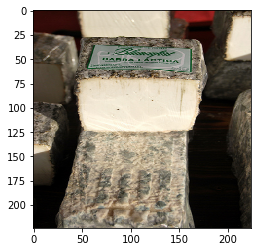

Cheese572.jpg is cheese 100.0 % sure.


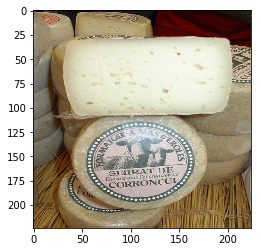

Cheese592.jpg is cheese 99.93566870689392 % sure.


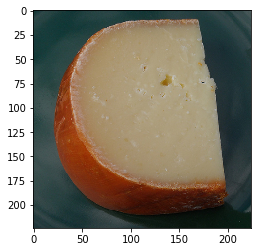

Cheese603.jpg is milk 85.61602830886841 % sure.


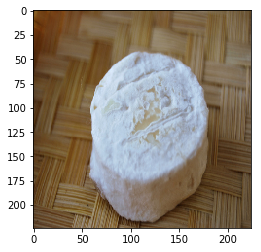

Cheese611.jpg is cheese 100.0 % sure.


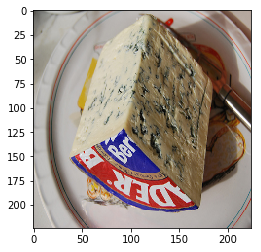

Cheese627.jpg is cheese 99.99929666519165 % sure.


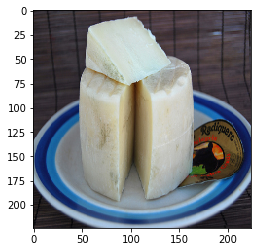

Cheese628.jpg is cheese 96.0958480834961 % sure.


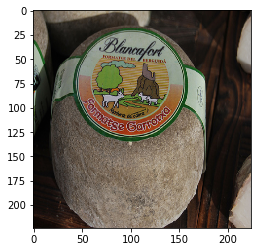

Cheese632.jpg is cheese 81.45399689674377 % sure.


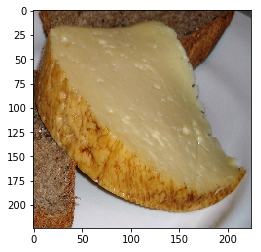

Cheese636.jpg is cheese 99.9925971031189 % sure.


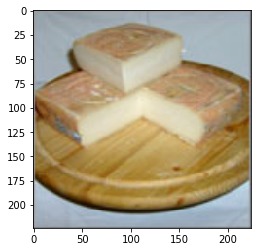

Cheese637.jpg is yogurt 99.32125806808472 % sure.


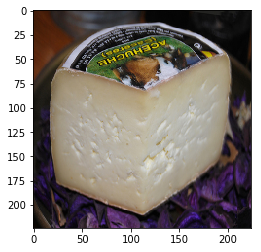

Cheese642.jpg is cheese 99.99982118606567 % sure.


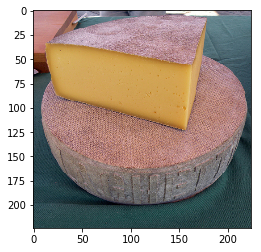

Cheese646.jpg is cheese 99.99405145645142 % sure.


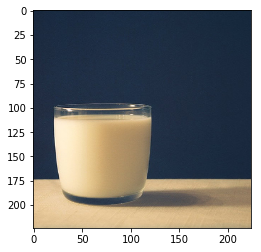

Milk1002.jpg is milk 99.64107871055603 % sure.


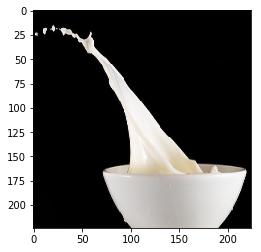

Milk1018.jpg is milk 99.07139539718628 % sure.


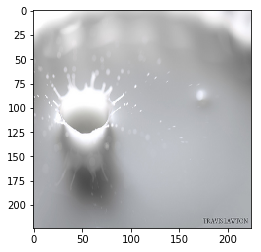

Milk1029.jpg is milk 100.0 % sure.


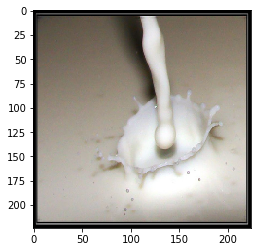

Milk1038.jpg is milk 99.99990463256836 % sure.


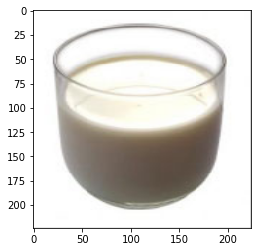

Milk1056.jpg is milk 100.0 % sure.


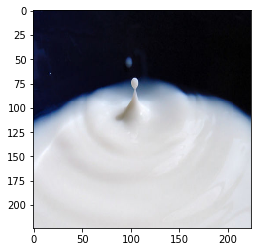

Milk1087.jpg is milk 99.9970555305481 % sure.


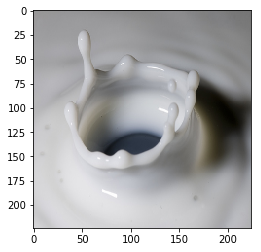

Milk1094.jpg is milk 99.18205738067627 % sure.


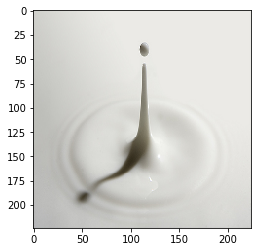

Milk1097.jpg is milk 100.0 % sure.


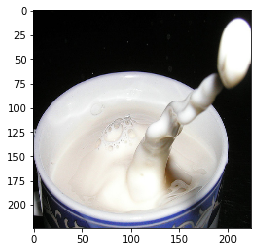

Milk1099.jpg is yogurt 91.07139706611633 % sure.


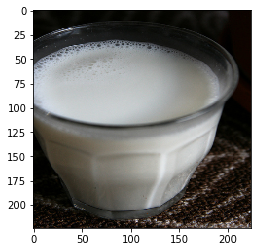

Milk1109.jpg is milk 99.99879598617554 % sure.


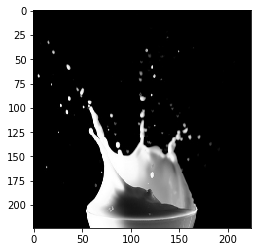

Milk858.jpg is milk 100.0 % sure.


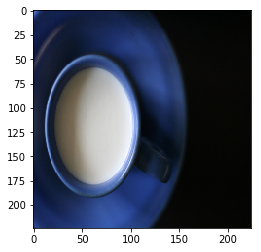

Milk864.jpg is milk 99.60882663726807 % sure.


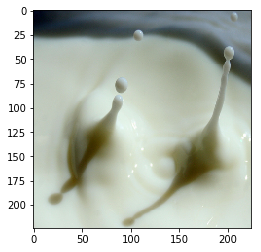

Milk869.jpg is milk 99.9954104423523 % sure.


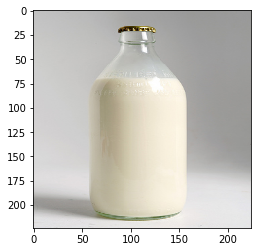

Milk874.jpg is milk 99.99998807907104 % sure.


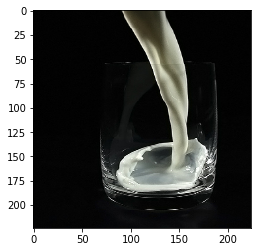

Milk900.jpg is milk 86.12673878669739 % sure.


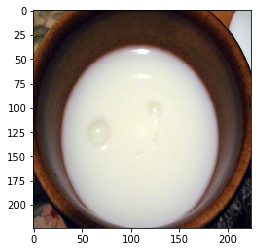

Milk911.jpg is yogurt 77.3974061012268 % sure.


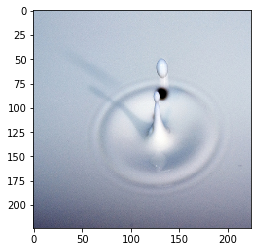

Milk952.jpg is milk 100.0 % sure.


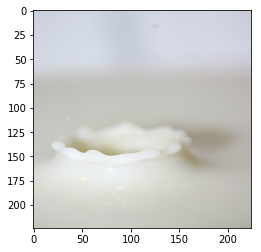

Milk984.jpg is milk 99.9998688697815 % sure.


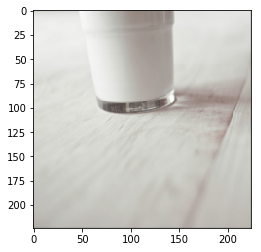

Milk986.jpg is milk 99.99992847442627 % sure.


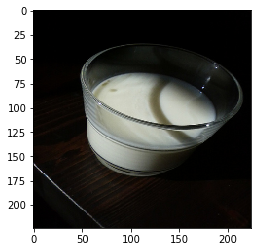

Milk996.jpg is milk 99.99676942825317 % sure.


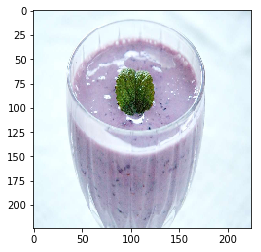

Yogurt1009.jpg is milk 98.91291856765747 % sure.


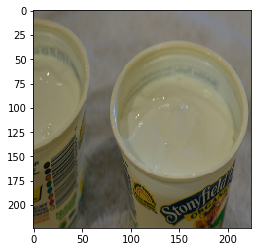

Yogurt1040.jpg is milk 93.92091035842896 % sure.


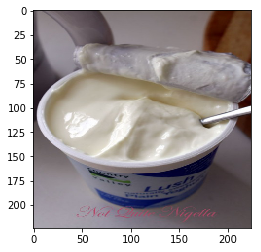

Yogurt1044.jpg is yogurt 100.0 % sure.


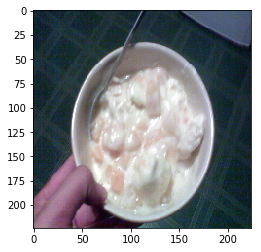

Yogurt1052.jpg is yogurt 99.99953508377075 % sure.


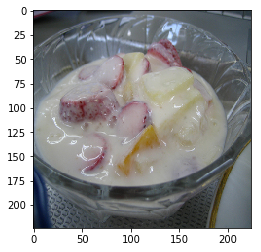

Yogurt1067.jpg is yogurt 100.0 % sure.


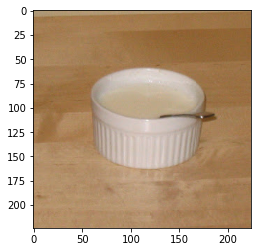

Yogurt1072.jpg is milk 99.99998807907104 % sure.


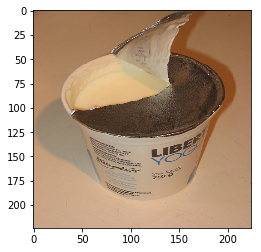

Yogurt1074.jpg is yogurt 99.71500039100647 % sure.


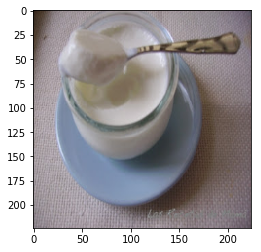

Yogurt843.jpg is yogurt 99.96813535690308 % sure.


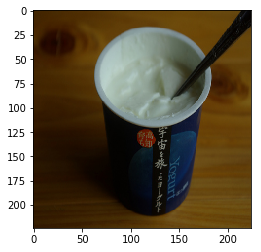

Yogurt873.jpg is yogurt 99.97147917747498 % sure.


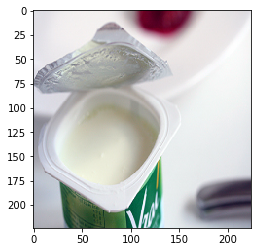

Yogurt875.jpg is yogurt 98.37613701820374 % sure.


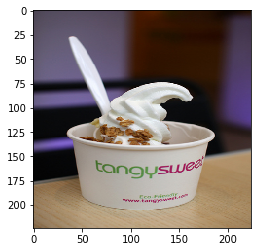

Yogurt955.jpg is yogurt 100.0 % sure.


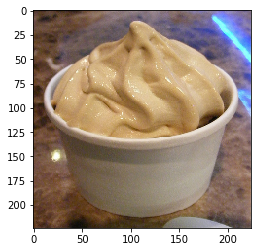

Yogurt971.jpg is yogurt 99.99963045120239 % sure.


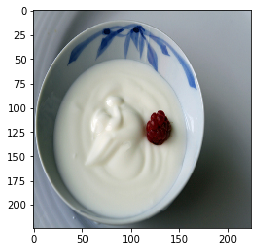

Yogurt982.jpg is yogurt 100.0 % sure.


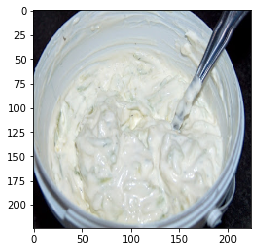

Yogurt988.jpg is yogurt 99.9982237815857 % sure.


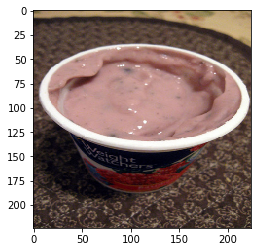

Yogurt989.jpg is yogurt 99.94127750396729 % sure.


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array
from skimage.transform import resize

def load_image(addr):
    # read an image and resize to (224, 224)
    # cv2 load images as BGR, convert it to RGB
    image = np.array(plt.imread(addr))
    image = resize(image, (224,224),mode='constant')
    return image

#directory = os.fsencode(directory_in_str)

for file in os.listdir(test_dir):
    filename = os.fsdecode(file)
    img = load_image(test_dir+"\\"+filename)  # Loads the image and resizes it to 224 x 224 x 3
    x = img_to_array(img)  # convert image to numpy array
    x = x.reshape((1,) + x.shape)  # prediction function is expecting an array of m images.  (1, 224, 224, 3)

    test_example = vgg_conv.predict(x)   #Calculate activation at last layer of VGG16 network.  (1, 7, 7, 512)

    test_example=np.reshape(test_example, (1, 7 * 7 * 512))  #Reshape to input expected to first layer of our model (1, 25088)

    #Input test_example to our model.  Output is the softmax results vector
    prob = model.predict(test_example)

    pred_class = np.argmax(prob) #Predicted class is the one with the highest probability in softmax vector
    pred_label = idx2label[pred_class]  #Get the corresponding label
    plt.imshow(x[0])
    plt.show()
    print(filename,"is",pred_label,prob[0,pred_class]*100,"% sure.")